# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [3]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


##Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer:

One of the first PCA dimensions could be the correlation between fresh and frozen, as fresh increases, we may expect frozen to decrease.
The ICA dimensions will have one element with a significantly larger magnitude than the rest

###PCA

In [4]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(data)


# Print the components and the amount of variance in the data contained in each dimension
# new_data = pca.transform(data)
# new_data_centered = preprocessing.scale(new_data)
# plt.scatter(new_data[:,0], new_data[:,1])
# plt.show()

# plt.scatter(new_data_centered[:,0], new_data_centered[:,1])
# plt.show()

print pd.DataFrame(pca.components_, columns=list(data.columns))
print "\n"

print "These are the explained variance ratios"
print pca.explained_variance_ratio_

      Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicatessen
0 -0.976537 -0.121184 -0.061540 -0.152365          0.007054     -0.068105
1 -0.110614  0.515802  0.764606 -0.018723          0.365351      0.057079
2 -0.178557  0.509887 -0.275781  0.714200         -0.204410      0.283217
3 -0.041876 -0.645640  0.375460  0.646292          0.149380     -0.020396
4  0.015986  0.203236 -0.160292  0.220186          0.207930     -0.917077
5 -0.015763  0.033492  0.410939 -0.013289         -0.871284     -0.265417


These are the explained variance ratios
[ 0.45961362  0.40517227  0.07003008  0.04402344  0.01502212  0.00613848]


**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

Answer: 

The variance drops off very quickly after the second principal component.  If using PCA on this dataset, I would select two dimensions for analysis. The goal of PCA is to reduce the number of dimensions while keeping the maximum amount of information possible.  Using just the first two dimensions, we are able to explain roughly 86% of the variation in the data.

**3)** What do the dimensions seem to represent? How can you use this information?

Answer: 

The first dimension is made up of mostly Fresh, and to a lesser degree Milk and Frozen.  These could potentially be "healthy" grocery store customers (like a Whole Foods).

The second dimension is made up of Grocery, then Milk, then Detergents_Paper. These could represent customers which are similar to convenience stores.

We can use this information to reduce the number of features from six down to two.  We can remove the dimensions with the least amount of information, and represent the data in only two dimensions. This in turn avoids the curse of dimensionality, and also simplifies computation within applied machine learning algorithms.


###ICA

In [14]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn import preprocessing
data_centered = preprocessing.scale(data)

from sklearn.decomposition import FastICA
ica = FastICA(n_components=6, random_state=1)
ica.fit_transform(data_centered)

# Print the independent components
print pd.DataFrame(ica.components_, columns=list(data.columns))


      Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicatessen
0 -0.003779  0.017044  0.114363 -0.007097         -0.134320     -0.016143
1  0.050228 -0.006338 -0.005963 -0.003283          0.009856     -0.002933
2  0.010930  0.001036 -0.007347 -0.054050          0.002641      0.016767
3 -0.001942 -0.072575  0.055168  0.001763         -0.015817      0.017061
4 -0.004882 -0.001618 -0.005699 -0.002532          0.002428      0.050965
5 -0.002655  0.013881 -0.061187 -0.001982          0.004058      0.004122


**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer: 

The first vector is comprised of Grocery and not Detergents_Paper.  This could correspond to restaurant customers.

The second vector is comprised almost entirely of Fresh.  These could represent the "healthy" grocery stores.

The third vector is comprised of Fresh and Delicatessen, and not Frozen.  These could also correspond to restaurant customers.

The fourth vector is comprised of Grocery and not Milk.  This could correspond to large super-stores like Walmart or Target.

The fifth vector is comprised almost entirely of Delicatessen.  These could correspond to sandwich shops (or delis).

The sixth vector is comprised of Milk and not Grocery.  This could correspond to ice cream parlor customers.

These components can be used as new features which are statisically independent.  This is extremely helpful when attempting classification or generating decision boundaries.

##Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

###Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer: 

K Means clustering will cluster the data points using "hard clustering", meaning that a point only belongs to one cluster.  Gaussian Mixture Models will cluster data points using "soft clustering", meaning that a point can belong to multiple clusters.  In soft clustering, the point is assigned a probability that it appears in a partucular cluster.

K Means clustering is guaranteed to converge to a local optimum; in order to converge on a global optimum, it must be run multiple times.

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [59]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [60]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation
clusterPCA = PCA(n_components=2)
clusterPCA.fit(data)
reduced_data = clusterPCA.transform(data)

# Print the components and the amount of variance in the data contained in each dimension
print pd.DataFrame(clusterPCA.components_, columns=list(data.columns))
print "\n"
print "Dimension 1 has {0:.5f} variance".format(clusterPCA.explained_variance_ratio_[0])
print "Dimension 2 has {0:.5f} variance".format(clusterPCA.explained_variance_ratio_[1])

      Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicatessen
0 -0.976537 -0.121184 -0.061540 -0.152365          0.007054     -0.068105
1 -0.110614  0.515802  0.764606 -0.018723          0.365351      0.057079


Dimension 1 has 0.45961 variance
Dimension 2 has 0.40517 variance


In [69]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'
clusters = GMM(n_components=6)
clusters.fit(reduced_data)

clusters2 = KMeans(n_clusters=6)
clusters2.fit(reduced_data)

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=6, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

In [70]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

Z2 = clusters2.predict(np.c_[xx.ravel(), yy.ravel()])

In [71]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 

centroids = clusters.means_
centroids2 = clusters2.cluster_centers_ 

print centroids
print centroids2

[[  9533.08979559   2875.86777608]
 [ -5775.25608572  -2804.02019039]
 [-31722.83442405  -6802.26852706]
 [-18416.8385771   45914.98214137]
 [  2917.75633744  -7172.67502341]
 [  3172.01367966  13259.54628747]]
[[  6035.6523743   -5702.59417982]
 [-20964.64986166  68819.21772923]
 [-37704.64157991  -5488.35405895]
 [  7177.17913696   6446.09370654]
 [  2787.06628956  24275.2601508 ]
 [ -9351.85448379  -4667.83404401]]


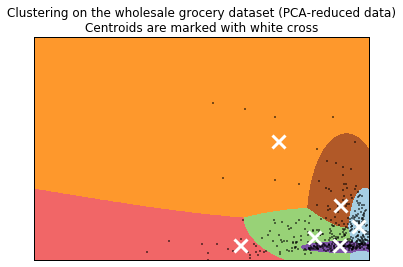

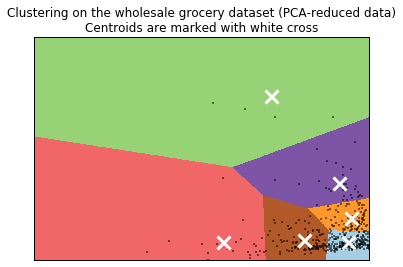

In [72]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

# Put the result into a color plot
Z2 = Z2.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z2, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids2[:, 0], centroids2[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

**7)** What are the central objects in each cluster? Describe them as customers.

Answer: 
The central object in each cluster is the data point that minimizes the distance between itself and every other point in the cluster.

It ideally represents the average customer within that cluster.

###Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer: 

**9)** How would you use that technique to help the company design new experiments?

Answer: 

**10)** How would you use that data to help you predict future customer needs?

Answer: 

In [73]:
def biplot(df):
    # Fit on 2 components
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2, whiten=True).fit(df)
    
    # Plot transformed/projected data
    ax = pd.DataFrame(
        pca.transform(df),
        columns=['PC1', 'PC2']
    ).plot(kind='scatter', x='PC1', y='PC2', figsize=(10, 8), s=0.8)

    # Plot arrows and labels
    for i, (pc1, pc2) in enumerate(zip(pca.components_[0], pca.components_[1])):
        ax.arrow(0, 0, pc1, pc2, width=0.001, fc='orange', ec='orange')
        ax.annotate(df.columns[i], (pc1, pc2), size=12)

    return ax

(-0.25, 1)

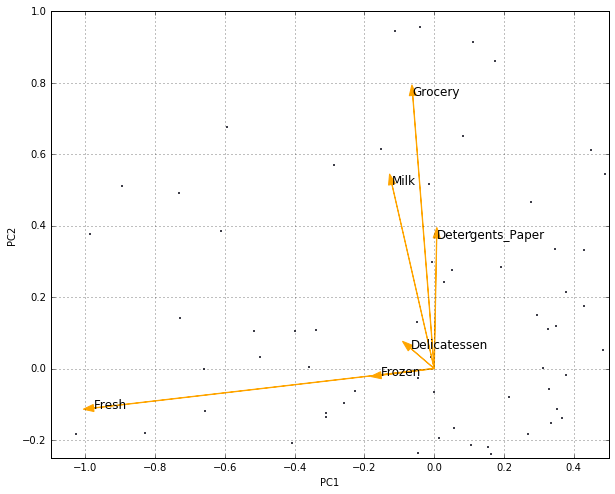

In [74]:
ax = biplot(data)
# Play around with the ranges for scaling the plot
ax.set_xlim([-1.1, .5])
ax.set_ylim([-.25, 1])